# README
SVM is tried on the Joint (mediapipe-produced) dataset. One expanded variants are tried. The models discussed in the paper are noted in the code.

Along with other models not in the paper, SVM (joint) expanded for both all joints and only distances from the wrist to fingers are attempted in this file.

![](https://mediapipe.dev/images/mobile/hand_landmarks.png)

# Load data

## Standard

In [1]:
!pip install datasets

from datasets import load_dataset

In [2]:
!pip install mediapipe

#mediapipe dependencies
import mediapipe as mp

In [3]:
#torch dependencies
from torch.utils.data import DataLoader
from transformers import AutoImageProcessor, ResNetForImageClassification
from torchvision import transforms
from torchvision.transforms.functional import to_pil_image
import torchvision
import torch

#general dependencies
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import numpy as np
import cv2
from PIL import Image
import shutil
import os

In [4]:
# Stringify a numeric label into textual form
def decode_label(label):
    if label == 1:
        return "rock"
    elif label == 0:
        return "paper"
    elif label == 2:
        return "scissors"
    elif label == 3:
        return "none"
    return None
    # return "rock" if label == 1 else "paper" if label == 0 else "scissors"

# grey scale images (channel 1)
def grey_scale():
  transform = transforms.Compose([
      transforms.Resize(256),
      transforms.Grayscale(num_output_channels=1),
  ])
  return transform

# returns a transformed image of shape (300, 300, 3)
def rgb_image_transform(image): # input type PIL.PngImagePlugin.PngImageFile
  resized_image = image.resize((300, 300))
  if resized_image.mode != 'RGB':
    resized_image = resized_image.convert('RGB')

  return resized_image

# returns a numpy (tensor) of an image
def image_numpy(image):
  np_image = np.array(image)

  return np_image


In [5]:
#Utility from Henry
from scipy.spatial.distance import euclidean
import numpy as np
import re
from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC

def parse_landmarks(landmarks_str):
    matches = re.findall(r'landmark \{\s*x: ([e\d.-]+)\s*y: ([e\d.-]+)\s*z: ([e\d.-]+)\s*\}', landmarks_str)
    landmarks = [(float(x), float(y), float(z)) for x, y, z in matches]
    return landmarks

def calculate_distances(landmarks):
    wrist = landmarks[0]
    fingertips_indexes = [4, 8, 12, 16, 18]
    distances = [euclidean(wrist, landmarks[i]) for i in fingertips_indexes]
    return distances

In [6]:
ds = load_dataset("conjunct/rps_annotated")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Generating train split:   0%|          | 0/9170 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/2035 [00:00<?, ? examples/s]

# SVM

SVMs are trained on the expanded dataset after being passed through joint.

Data is included only if mediapipe annotations are present. (Note: ~7% of kaggle dataset do not have annotations due not being fully in frame)

In [7]:
# create labels
labels = []
labels_test = []

for i, row in enumerate(ds['train']):
    landmarks = row['landmarks']
    if landmarks:
        labels.append(row['label'])
    else:
        pass


for i, row in enumerate(ds['test']):
    landmarks = row['landmarks']
    if landmarks:
        labels_test.append(row['label'])
    else:
        pass

labels_array = np.array(labels)
labels_array_test = np.array(labels_test)

## Using all joints

Described in the paper as the SVM (joint) on expanded dataset, with all joints

In [8]:
from itertools import chain

features = []
features_test = []

NUM_DISTANCES = 4 # len(calculate_distances(ds_v3['train'][4100]['landmarks']))
for i, row in enumerate(ds['train']):
    landmarks = row['landmarks']
    if landmarks:
        features.append(list(chain.from_iterable(landmarks))[:21*3]) # flatten list
        if row['label'] == 3:
            print(f"Landmark detected for train row {i}")
    else:
        pass
        # features.append([0] * NUM_DISTANCES)


for i, row in enumerate(ds['test']):
    landmarks = row['landmarks']
    if landmarks:
        features_test.append(list(chain.from_iterable(landmarks))[:21*3]) # flatten list
        if row['label'] == 3:
            print(f"Landmark detected for test row {i}")
    else:
        # features
        pass


features_array = np.array(features)
features_array_test = np.array(features_test)

Landmark detected for train row 5648
Landmark detected for train row 5988
Landmark detected for train row 6488
Landmark detected for test row 1866
Landmark detected for test row 1867


Accuracy: 0.9223057644110275
Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.76      0.86       252
           1       0.88      1.00      0.93       265
           2       0.92      1.00      0.96       279
           3       0.00      0.00      0.00         2

    accuracy                           0.92       798
   macro avg       0.70      0.69      0.69       798
weighted avg       0.93      0.92      0.92       798



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


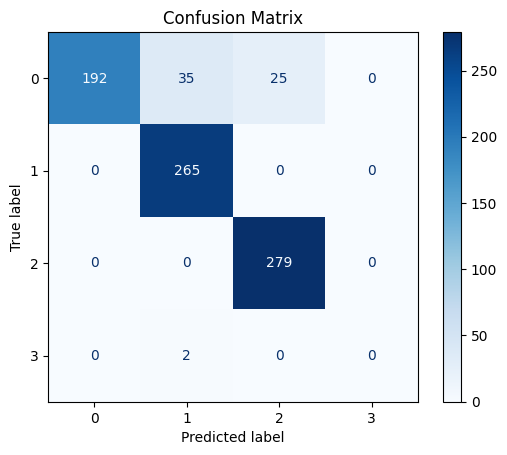

In [9]:
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.svm import SVC

# Initialize and train an SVM classifier
svm_model = SVC(kernel='rbf')
svm_model.fit(features_array, labels_array)

# Predict labels for the test set
y_pred = svm_model.predict(features_test)

# Evaluate the model
print("Accuracy:", accuracy_score(labels_test, y_pred))
print("Classification Report:")
print(classification_report(labels_test, y_pred))

cm = confusion_matrix(labels_test, y_pred, labels=svm_model.classes_)

# Display the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=svm_model.classes_)

disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()

## Using just distances between wrist and fingers("5-dist")

Discussed in paper in as SVM (Joint) on expanded dataset (wrist to fingers)

In [10]:
from itertools import chain

features_dists = []
features_dists_test = []

NUM_DISTANCES = 4 # len(calculate_distances(ds_v3['train'][4100]['landmarks']))
for row in ds['train']:
    landmarks = row['landmarks']
    if landmarks:
        distances = calculate_distances(landmarks)
        features_dists.append(distances)
    else:
        pass


for row in ds['test']:
    landmarks = row['landmarks']
    if landmarks:
        distances = calculate_distances(landmarks)
        features_dists_test.append(distances) # flatten list
    else:
        # features
        pass

In [11]:
features_array_dists = np.array(features_dists)

features_array_dists_test = np.array(features_dists_test)

In [12]:
features_array_dists_test.shape

(798, 5)

Accuracy: 0.9987468671679198
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       252
           1       1.00      1.00      1.00       265
           2       1.00      1.00      1.00       279
           3       1.00      0.50      0.67         2

    accuracy                           1.00       798
   macro avg       1.00      0.88      0.92       798
weighted avg       1.00      1.00      1.00       798



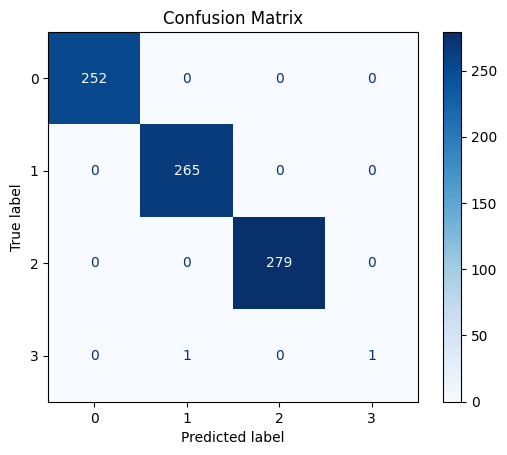

In [13]:
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.svm import SVC

# Initialize and train an SVM classifier
svm_model = SVC(kernel='rbf')
svm_model.fit(features_array_dists, labels_array)

# Predict labels for the test set
y_pred = svm_model.predict(features_array_dists_test)

# Evaluate the model
print("Accuracy:", accuracy_score(labels_test, y_pred))
print("Classification Report:")
print(classification_report(labels_test, y_pred))

cm = confusion_matrix(labels_test, y_pred, labels=svm_model.classes_)

# Display the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=svm_model.classes_)

disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()

## 5-dist with variant: ignore z

In [14]:
from itertools import chain

features_dists_noz = []
features_dists_noz_test = []

NUM_DISTANCES = 4 # len(calculate_distances(ds_v3['train'][4100]['landmarks']))
for row in ds['train']:
    landmarks = row['landmarks']
    if landmarks:
        remove_z = [(x, y) for (x, y, _) in landmarks]
        distances = calculate_distances(remove_z)
        features_dists_noz.append(distances)
    else:
        pass


for row in ds['test']:
    landmarks = row['landmarks']
    if landmarks:
        remove_z = [(x, y) for (x, y, _) in landmarks]
        distances = calculate_distances(remove_z)
        features_dists_noz_test.append(distances) # flatten list
    else:
        # features
        pass

In [15]:
features_array_dists = np.array(features_dists_noz)
features_array_dists_test = np.array(features_dists_noz_test)

Accuracy: 0.9987468671679198
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       252
           1       1.00      1.00      1.00       265
           2       1.00      1.00      1.00       279
           3       1.00      0.50      0.67         2

    accuracy                           1.00       798
   macro avg       1.00      0.88      0.92       798
weighted avg       1.00      1.00      1.00       798



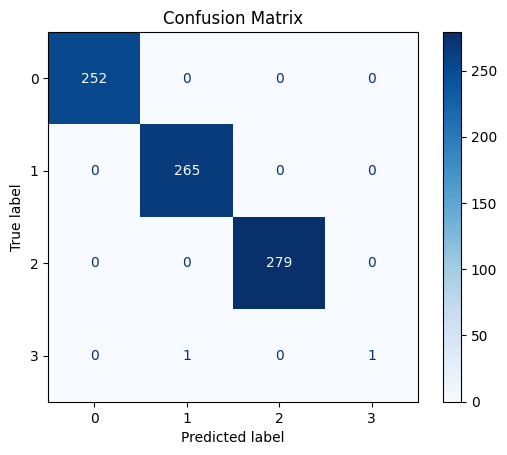

In [16]:
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.svm import SVC

# Initialize and train an SVM classifier
svm_model = SVC(kernel='rbf')
svm_model.fit(features_array_dists, labels_array)

# Predict labels for the test set
y_pred = svm_model.predict(features_array_dists_test)

# Evaluate the model
print("Accuracy:", accuracy_score(labels_test, y_pred))
print("Classification Report:")
print(classification_report(labels_test, y_pred))

cm = confusion_matrix(labels_test, y_pred, labels=svm_model.classes_)

# Display the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=svm_model.classes_)

disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()

save model

In [17]:
import pickle
with open("svm_no_z.pkl", 'wb') as f:
    pickle.dump(svm_model, f)

## How to run SVM without retraining

In [22]:
!gdown --fuzzy https://drive.google.com/file/d/1-8hm-quWlYfQeXkMeR_lhkMxqV-d-Nkq/view?usp=drive_link

Downloading...
From: https://drive.google.com/uc?id=1-8hm-quWlYfQeXkMeR_lhkMxqV-d-Nkq
To: /content/svm.pkl
100% 24.4k/24.4k [00:00<00:00, 56.7MB/s]


In [23]:
with open("svm.pkl", 'rb') as f:
    svm_model = pickle.load(f)

# Extra Commented Out Code

## Expand to see false positives from mediapipe
These images have joint landmarks added even though they are not rock, paper, or scissors

In [25]:
# import matplotlib.pyplot as plt
# fig, ax = plt.subplots(1,5, figsize=(40,40))
# for i, image in enumerate(images_list):
#     ax[i].imshow(image)
#     ax[i].axis('off')